#1. Introdução

Agora para a modelagem, vamos investigar se alguns padrões latentes nas características de marcha permitem agrupamentos entre indivíduos com e sem Parkinson.

Serão aplicadas técnicas de redução de dimensionalidade, como PCA, e métodos de agrupamento, como K-means, com o intuito de explorar padrões ocultos, possíveis subestruturas entre os sujeitos e relações com a severidade clínica.

# 2. Preparação dos Dados

Os dados explorados anteriormente na fase de EDA são organizados para a modelagem não supervisionada.

Para cada sujeito, serão calculadas estatísticas agregadas das variáveis de marcha, incluindo:

- Média

- Desvio padrão

- Coeficiente de variação

## 2.1 - Selecionando as variáveis

Montamos o Google Drive para acessar a base de dados e importamos as bibliotecas necessárias.

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Como primeiro teste, vamos usar somente o estudo **Ga**

In [ ]:
BASE_PATH = "/content/drive/MyDrive/gait-in-parkinsons-disease-1.0.0"

ga_files = sorted(glob.glob(os.path.join(BASE_PATH, "Ga*.txt")))

print("Total de arquivos Ga encontrados:", len(ga_files))


Total de arquivos Ga encontrados: 113


## 2.2 - Agregação Estatística por Estudo

Extrai features estatísticas de um único arquivo de dados de marcha.

Para cada pé e para a soma de ambos, calcularemos:
- **Média**: Tendência central da força aplicada.
- **Desvio Padrão (std)**: Variabilidade da força.
- **Coeficiente de Variação (cv)**: Uma medida de variabilidade normalizada pela média (`std / mean`), útil para comparar a dispersão relativa.
- **Máximo (max)** e **Mínimo (min)**: Valores extremos da força.
- **Assimetria**: A diferença entre a força média do pé esquerdo e do direito (`assim_mean` e `assim_abs`)

In [ ]:
def extract_features_ga(path, tmax=120):

    df = pd.read_csv(path, sep=r"\s+", header=None)
    df = df[df[0] <= tmax]

    total_L = df[17]
    total_R = df[18]
    total_sum = total_L + total_R

    features = {}

    # Pé esquerdo
    features["mean_L"] = total_L.mean()
    features["std_L"]  = total_L.std()
    features["cv_L"]   = total_L.std() / total_L.mean()
    features["max_L"]  = total_L.max()
    features["min_L"]  = total_L.min()

    # Pé direito
    features["mean_R"] = total_R.mean()
    features["std_R"]  = total_R.std()
    features["cv_R"]   = total_R.std() / total_R.mean()
    features["max_R"]  = total_R.max()
    features["min_R"]  = total_R.min()

    # Combinadas
    features["mean_total"] = total_sum.mean()
    features["std_total"]  = total_sum.std()
    features["assim_mean"] = features["mean_L"] - features["mean_R"]
    features["assim_abs"]  = abs(features["assim_mean"])

    return features

## 2.3 - Normalização dos Dados

In [ ]:
# Aplica a função de extração a todos os arquivos
data = []

for path in ga_files:

    fname = os.path.basename(path).replace(".txt", "")

    # Extrair subject_id
    subject_id = fname[:6]

    features = extract_features_ga(path)

    features["subject_id"] = subject_id
    features["file_name"] = fname

    data.append(features)

df_ga = pd.DataFrame(data)

print("Shape nível arquivo:", df_ga.shape)
df_ga.head()

Shape nível arquivo: (113, 16)


,mean_L,std_L,cv_L,max_L,min_L,mean_R,std_R,cv_R,max_R,min_R,mean_total,std_total,assim_mean,assim_abs,subject_id,file_name
0,520.728249,458.432657,0.880368,1159.95,0.0,563.311008,491.309396,0.872181,1257.30,0.0,1084.039258,138.159611,-42.582759,42.582759,GaCo01,GaCo01_01
1,441.761787,373.468165,0.845406,1046.43,0.0,447.610330,387.790645,0.866358,1086.25,0.0,889.372117,111.341489,-5.848543,5.848543,GaCo02,GaCo02_01
2,429.683520,373.371045,0.868944,1032.24,0.0,449.212356,390.316652,0.868891,1099.56,0.0,878.895875,124.255551,-19.528836,19.528836,GaCo02,GaCo02_02
3,600.768598,498.350624,0.829522,1304.93,0.0,591.216040,513.934437,0.869284,1271.49,0.0,1191.984638,148.809746,9.552557,9.552557,GaCo03,GaCo03_01
4,615.700724,531.570259,0.863358,1427.69,0.0,602.912145,524.753258,0.870364,1348.27,0.0,1218.612869,172.480125,12.788579,12.788579,GaCo03,GaCo03_02


## 2.4 - Agregação por Sujeito

Adicionamos uma coluna para identificar se o sujeito pertence ao grupo de controle (CO) ou com Parkinson (PD), com base no seu identificador.

In [ ]:
def identify_group(subject_id):
    if "Co" in subject_id:
        return "CO"
    elif "Pt" in subject_id:
        return "PD"
    else:
        return "Unknown"

df_ga["Group"] = df_ga["subject_id"].apply(identify_group)

df_ga["Group"].value_counts()

,count
Group,
PD,75
CO,38


O objetivo é agrupar sujeitos, precisamos agregar as informações dos múltiplos arquivos (testes) para cada indivíduo. Faremos isso calculando a média e o desvio padrão de cada feature ao longo dos diferentes testes

In [ ]:
# Features estatísticas extraídas anteriormente
feature_cols = [
    'mean_L', 'std_L', 'cv_L', 'max_L', 'min_L',
    'mean_R', 'std_R', 'cv_R', 'max_R', 'min_R',
    'mean_total', 'std_total', 'assim_mean', 'assim_abs'
]

# Agrupar por sujeito
agg_mean = df_ga.groupby("subject_id")[feature_cols].mean()
agg_std  = df_ga.groupby("subject_id")[feature_cols].std()

# Renomear colunas
agg_mean.columns = [f"{col}_meanSubj" for col in agg_mean.columns]
agg_std.columns  = [f"{col}_stdSubj" for col in agg_std.columns]

# Concatenar
df_ga_subject = pd.concat([agg_mean, agg_std], axis=1)

print("Shape após agregação por sujeito:", df_ga_subject.shape)
df_ga_subject.head()

Shape após agregação por sujeito: (47, 28)


,mean_L_meanSubj,std_L_meanSubj,cv_L_meanSubj,max_L_meanSubj,min_L_meanSubj,mean_R_meanSubj,std_R_meanSubj,cv_R_meanSubj,max_R_meanSubj,min_R_meanSubj,...,min_L_stdSubj,mean_R_stdSubj,std_R_stdSubj,cv_R_stdSubj,max_R_stdSubj,min_R_stdSubj,mean_total_stdSubj,std_total_stdSubj,assim_mean_stdSubj,assim_abs_stdSubj
subject_id,,,,,,,,,,,,,,,,,,,,,
GaCo01,520.728249,458.432657,0.880368,1159.950,0.0,563.311008,491.309396,0.872181,1257.300,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GaCo02,435.722654,373.419605,0.857175,1039.335,0.0,448.411343,389.053649,0.867624,1092.905,0.0,...,0.0,1.132803,1.786157,0.001791,9.411591,0.0,7.407822,9.131620,9.673428,9.673428
GaCo03,608.234661,514.960441,0.846440,1366.310,0.0,597.064093,519.343847,0.869824,1309.880,0.0,...,0.0,8.270395,7.650062,0.000764,54.291659,0.0,18.829003,16.737486,2.288213,2.288213
GaCo04,400.038318,344.074302,0.860110,960.465,0.0,409.886297,346.941002,0.846430,1006.775,0.0,...,0.0,2.688795,2.562916,0.000700,17.812020,0.0,5.347315,0.041296,0.030274,0.030274
GaCo05,524.049661,427.151040,0.814991,1129.480,0.0,536.461205,445.656502,0.830661,1172.105,0.0,...,0.0,9.639408,12.334441,0.008066,12.211734,0.0,23.616725,2.941446,4.337909,4.337909


In [ ]:
# Adicionar grupo
df_ga_subject["Group"] = df_ga.groupby("subject_id")["Group"].first()

df_ga_subject["Group"].value_counts()

,count
Group,
PD,29
CO,18


## 3. Normalização

Usaremos o `StandardScaler`, que transforma cada feature para ter média 0 e desvio padrão 1. Isso será crucial para o uso do PCA.

In [ ]:
df_ga_subject = df_ga_subject.fillna(0)

In [ ]:
# Separar matriz de features
X = df_ga_subject.drop(columns=["Group"])

# Guardar rótulo apenas para avaliação posterior
y_group = df_ga_subject["Group"]

print("Shape da matriz X:", X.shape)

Shape da matriz X: (47, 28)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

print("Shape após normalização:", X_scaled.shape)

Shape após normalização: (47, 28)


In [ ]:
pd.DataFrame(X_scaled).describe().round(2)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,47.00,47.00,47.00,47.00,47.0,47.00,47.00,47.00,47.00,47.0,...,47.0,47.00,47.00,47.00,47.00,47.0,47.00,47.00,47.00,47.00
mean,0.00,-0.00,0.00,-0.00,0.0,0.00,0.00,0.00,-0.00,0.0,...,0.0,0.00,-0.00,-0.00,-0.00,0.0,-0.00,-0.00,-0.00,-0.00
std,1.01,1.01,1.01,1.01,0.0,1.01,1.01,1.01,1.01,0.0,...,0.0,1.01,1.01,1.01,1.01,0.0,1.01,1.01,1.01,1.01
min,-1.96,-2.03,-4.40,-1.81,0.0,-2.23,-2.37,-1.67,-2.10,0.0,...,0.0,-0.59,-0.82,-0.47,-1.01,0.0,-0.52,-0.63,-0.92,-1.05
25%,-0.69,-0.58,-0.44,-0.70,0.0,-0.55,-0.58,-0.75,-0.71,0.0,...,0.0,-0.45,-0.68,-0.40,-0.63,0.0,-0.43,-0.53,-0.70,-0.77
50%,-0.03,-0.13,0.02,-0.14,0.0,-0.04,-0.06,-0.07,-0.09,0.0,...,0.0,-0.21,-0.25,-0.24,-0.32,0.0,-0.23,-0.19,-0.33,-0.27
75%,0.60,0.70,0.50,0.72,0.0,0.60,0.58,0.60,0.58,0.0,...,0.0,0.07,0.23,-0.07,0.46,0.0,0.09,0.20,0.44,0.59
max,2.32,2.06,2.56,2.33,0.0,2.46,2.38,2.92,2.30,0.0,...,0.0,5.81,3.78,5.70,3.21,0.0,6.21,6.04,4.16,2.47


# 4. Reduzindo a dimensionalidade com o PCA

Para visualizar nossos dados de alta dimensionalidade (28 features) e entender sua estrutura, aplicaremos o PCA.

## 4.1 - Ajustar PCA e analisar variância **explicada**

Ajustamos o PCA em todos os dados para ver quantos componentes principais são necessários para explicar a maior parte da variância.

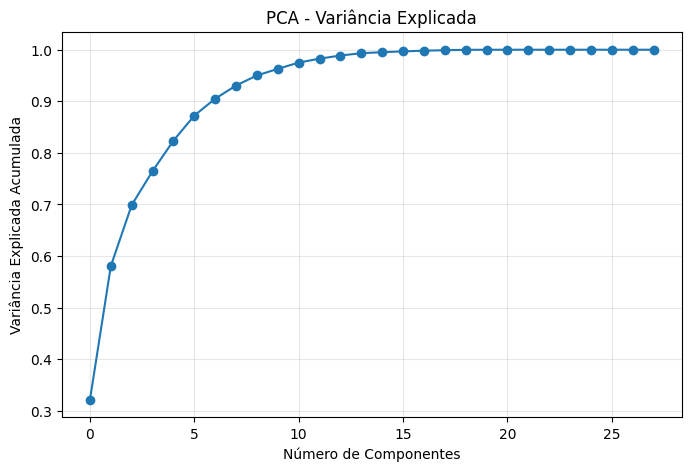

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)

# Variância explicada acumulada
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("PCA - Variância Explicada")
plt.grid(alpha=0.3)
plt.show()

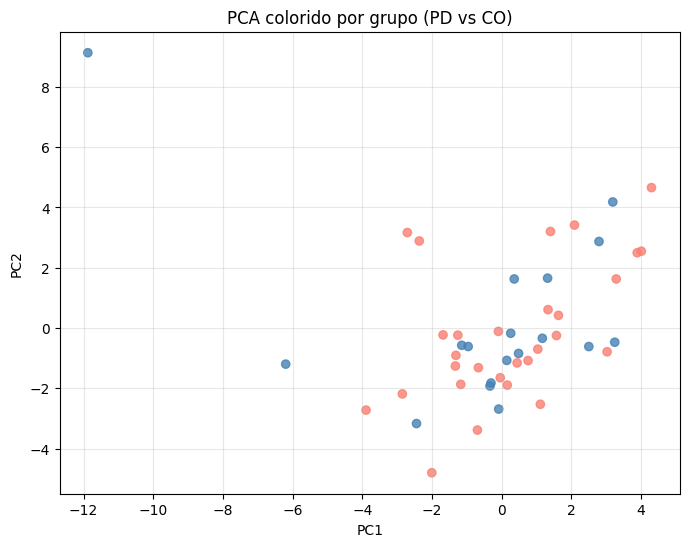

In [ ]:
#Reduzimos para 2 componentes para visualização
colors = y_group.map({"PD":"salmon", "CO":"steelblue"})

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA colorido por grupo (PD vs CO)")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
print("Variância explicada PC1:", pca_2d.explained_variance_ratio_[0])
print("Variância explicada PC2:", pca_2d.explained_variance_ratio_[1])
print("Total:", sum(pca_2d.explained_variance_ratio_))

Variância explicada PC1: 0.3214722917164038
Variância explicada PC2: 0.2591383926451232
Total: 0.580610684361527


# 5. Clustering com K-Means

Aplicaremos o algoritmo K-Means para tentar descobrir agrupamentos naturais nos dados, sem usar os rótulos de grupo.

Usaremos o Elbow Method e o Silhouette Analysis para estimar o valor de K.

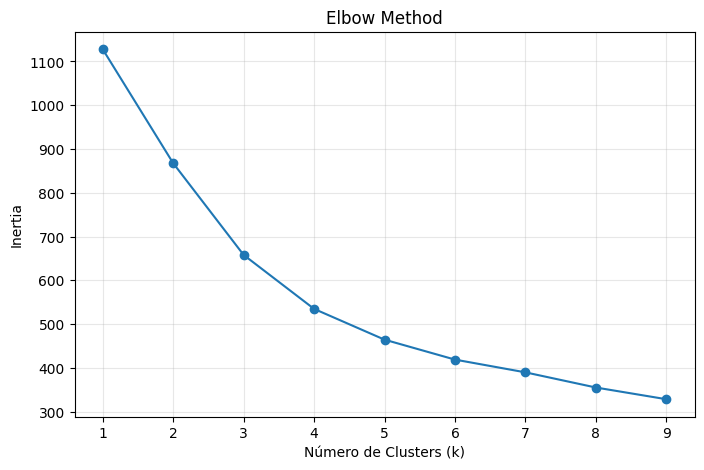

In [ ]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(1, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(alpha=0.3)
plt.show()

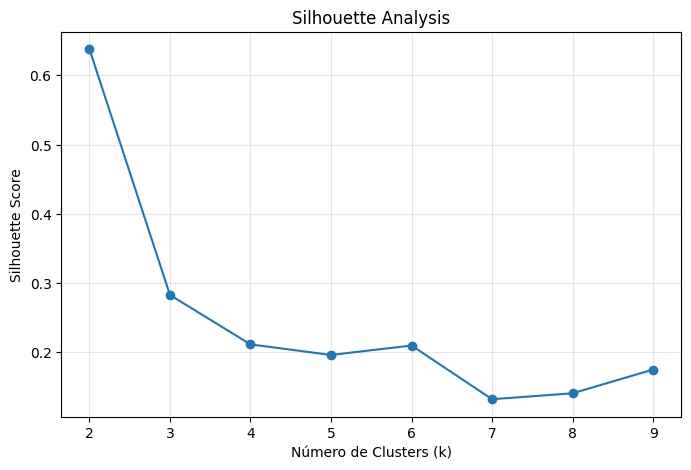

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(8,5))
plt.plot(k_range, sil_scores, marker="o")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.grid(alpha=0.3)
plt.show()

Com base nos gráficos acima (observando o "cotovelo" e o pico do silhouette score), escolheremos um valor para `k`. Neste caso, `k=2` ou `k=3` parecem ser candidatos razoáveis. Vamos explorar `k=3` para ver se o algoritmo encontra subgrupos interessantes.

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

df_ga_subject["Cluster"] = clusters

Vamos visualizar como o K-Means agrupou os dados, projetando-os novamente no espaço PCA 2D.

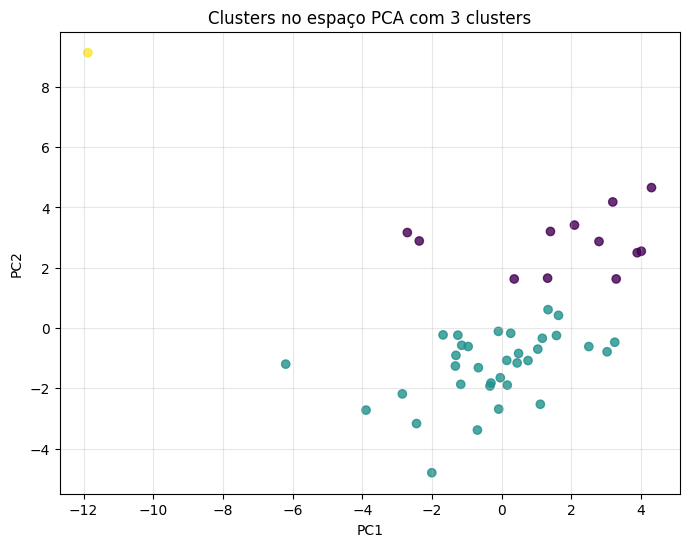

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap="viridis", alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Clusters no espaço PCA com 3 clusters")
plt.grid(alpha=0.3)
plt.show()

Concluindo, comparamos os clusters encontrados de forma não supervisionada com os grupos clínicos reais (PD vs. CO). Isso nos ajuda a entender se os padrões de marcha capturados pelo K-Means estão alinhados com o diagnóstico.

- A **tabela de contingência (crosstab)** mostra a distribuição dos grupos em cada cluster.
- O **Adjusted Rand Index (ARI)** é uma medida de similaridade entre duas partições (nossos clusters e os grupos reais), corrigida pelo acaso. Um valor próximo de 0 indica que os clusters são aleatórios em relação aos grupos, enquanto um valor próximo de 1 indica uma concordância perfeita.

In [ ]:
pd.crosstab(df_ga_subject["Group"], df_ga_subject["Cluster"])

Cluster,0,1,2
Group,,,
CO,4,13,1
PD,8,21,0


In [ ]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(df_ga_subject["Group"], df_ga_subject["Cluster"])
print("Adjusted Rand Index:", ari)

Adjusted Rand Index: 0.025926527958387516
